# Classification - Multi-Class
---

In [1]:
# Check GPU information
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import torch
from scripts.utils import plot_train_test_loss
from torch import nn
from pathlib import Path
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_SEED = 42

## 1. Get data ready (turn into tensor)

In [3]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.5, random_state=RANDOM_SEED)
X_tensor = torch.from_numpy(X).to(device=DEVICE).to(dtype=torch.float32)
y_tensor = torch.from_numpy(y).to(device=DEVICE).to(dtype=torch.long)

print(X_tensor.shape, y_tensor.shape)

torch.Size([1000, 2]) torch.Size([1000])


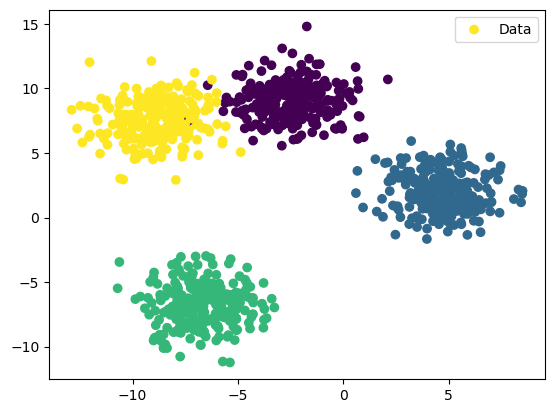

In [4]:
plt.scatter(X_tensor[:, 0].cpu().numpy(), X_tensor[:, 1].cpu().numpy(), label="Data", c=y_tensor.cpu().numpy())
plt.legend()
plt.show()

In [5]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=RANDOM_SEED)
print(len(X_train), len(X_test), len(y_train), len(y_test))

800 200 800 200


## 2. Build or pick a pretrained model for training

In [6]:
class MultiClassifier(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=15),
        nn.ReLU(),
        nn.Linear(in_features=15, out_features=out_features)
    ).to(device=DEVICE)
  
  def forward(self, X):
    return self.model(X)


model = MultiClassifier(in_features=2, out_features=4)
model.to(device=DEVICE)

MultiClassifier(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=4, bias=True)
  )
)

### 2.1 Pick loss function and optimizer

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

### 2.2 Build a training loop to train the model

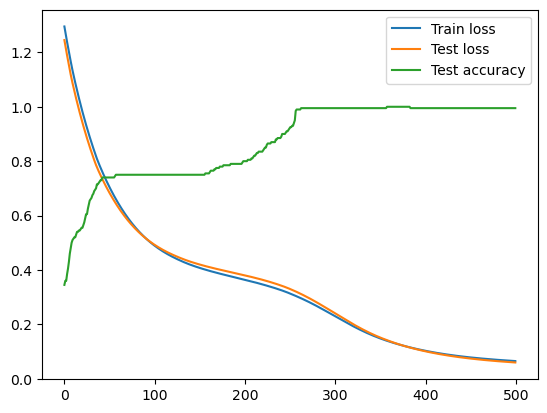

In [8]:
torch.manual_seed(RANDOM_SEED)

EPOCHS = 500
epoch_count = []
train_loss = []
test_loss = []
test_accuracy = []

for epoch in range(EPOCHS):
  epoch_count.append(epoch)

  # train
  model.train()
  y_logit = model(X_train)
  y_prob = torch.softmax(y_logit, dim=1)
  y_pred = y_prob.argmax(dim=1)
  loss = loss_fn(y_logit, y_train)
  train_loss.append(loss)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # evaluate
  model.eval()
  with torch.inference_mode():
    y_logit = model(X_test)
    y_prob = torch.softmax(y_logit, dim=1)
    y_pred = y_prob.argmax(dim=1)
    loss = loss_fn(y_logit, y_test)
    test_loss.append(loss)
    acc = accuracy_score(y_test.cpu().numpy(), y_pred.cpu().numpy())
    test_accuracy.append(acc)

plot_train_test_loss(epoch_count, train_loss, test_loss, test_accuracy)

## 3. Make prediction

In [9]:
model.eval()
with torch.inference_mode():
  y_logit = model(X_test)
  y_prob = torch.softmax(y_logit, dim=1)
  y_pred = y_prob.argmax(dim=1)
  loss = loss_fn(y_logit, y_test)
  acc = accuracy_score(y_test.cpu().numpy(), y_pred.cpu().numpy())

print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

Loss: 0.05966981500387192
Accuracy: 0.995


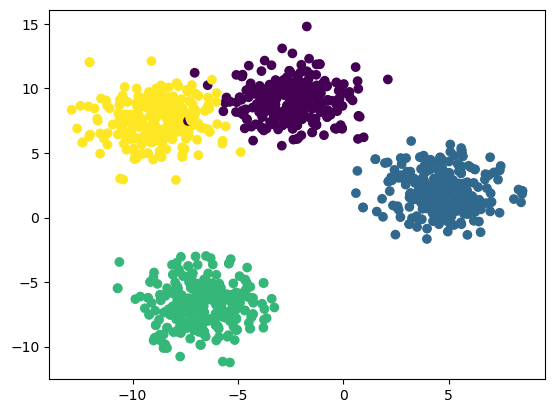

In [10]:
# Special plot function for classification
def plot_predictions(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=None
):
  X_train = X_train.cpu().numpy()
  X_test = X_test.cpu().numpy()
  y_train = y_train.cpu().numpy()
  y_test = y_test.cpu().numpy()
  if y_pred is not None:
    y_pred = y_pred.cpu().numpy()
  plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
  if y_pred is not None:
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

plot_predictions(y_pred=y_pred)

## 4. Evaluate the model

## 5. Improve through experimentation

## 6. Save and reload trained model

In [11]:
# Save the model

model_folder = Path("models")
model_folder.mkdir(parents=True, exist_ok=True)
model_name = "classification_multi_class_pytorch.pt"
model_path = model_folder / model_name

model.to(device=DEVICE)
torch.save(obj=model.state_dict(), f=model_path)

In [ ]:
# Load the model

loaded_model = MultiClassifier(in_features=2, out_features=4)
loaded_model.load_state_dict(torch.load(f=model_path))
loaded_model.to(device=DEVICE)
loaded_model.state_dict()

In [13]:
# Verify if the loading worked correctly

model.eval()
with torch.inference_mode():
  loaded_y_logit = model(X_test)
  loaded_y_prob = torch.softmax(loaded_y_logit, dim=1)
  loaded_y_pred = loaded_y_prob.argmax(dim=1)
  loaded_loss = loss_fn(loaded_y_logit, y_test)

print(y_prob == loaded_y_prob)
print(loaded_loss == loss)

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True,